# Applying BOLD HRFs to Neural Time Series

The BOLD monitor in TVB calculates the haemodynamic response (i.e. 'fMRI activity') associated with a given neural activity time series. This can be obtained as an output from a TVB simulation.

But sometimes one wants to calculate BOLD directly from a set of numbers (e.g. non-TVB simulations; from physiological recording data, etc.). 

The following notes show how to do this. 

## Contents
* [Background](#Background)
* [Notebook Setup](#Notebook-Setup)
* [Generate simulation data](#Generate-simulation-data)
* [Computing BOLD signal post-hoc ](#Computing-BOLD-signal-post-hoc)
* [Additional Notes](#Additional-Notes)

## Background

BOLD signal is calculated in TVB using convolution with a haemodynamic response function kernel. 

Alternative ways of doing this I have seen by e.g. Gus Deco is to numerically integrate a separate ODE for the BOLD signal. 

But here we will be following the convolution approach.
 
Jarrod Millman's fmri stats lectures [here](http://www.jarrodmillman.com/rcsds/lectures/convolution_background.html) and [here](http://nbviewer.ipython.org/github/practical-neuroimaging/pna-notebooks/blob/master/convolution.ipynb) are extremely useful and practical background reading on convolution in the context of event-related fMRI analysis. The wikipedia page on convolution is also very good, with some nice visual demonstrations of the concepts. 

In terms of the TVB implementation, the following is essentially continuing from the ['exploring the BOLD monitor' demo](https://github.com/the-virtual-brain/tvb-documentation/blob/master/demos/exploring_the_bold_monitor.ipynb), which shows how to visualize the HRF kernel shape. So check that out first for a bit more context.

Now we get to an important point, and also the reason why it seems worth writing these notes out in a reasonably coherent form: When I first started looking into this, my initial plan was simply to use directly whatever function TVB uses for calculating BOLD internally. 

However, after pouring over the [BOLD monitor code](https://github.com/the-virtual-brain/tvb-library/blob/trunk/tvb/simulator/monitors.py#L741), and asking around a bit, it became pretty clear that that probably isn't the most sensible approach. 

In a nutshell, the reasons for this are that 

- the BOLD monitor has to do a number of things related to the in-step sampling of neural activity during that would simply be unnecessarily clunky to reproduce directly when one already has a complete time series    
- pandas has some nice moving window average functions that make life a lot easier  
- it seems more straightforward to use `numpy.convolve` rather than write out the convolution explicitly, as is done in the monitor code



The basic aim of the following notes is to construct a function that takes as input a (simulated) neural time series (temporal average monitor), and returns as output a BOLD signal that matches reasonably closely to the BOLD monitor output from the same simulation. 

A secondary aim is to explain a few things here and there along the way. 

## Notebook Setup

Define some variables

In [17]:
tvb_lib_folder = '~/Code/libraries_of_others/tvb-library'
tvb_dat_folder = '~/Code/libraries_of_others/tvb-data'

data_dir = '../data'

Importage

In [18]:
import os,sys,glob,numpy as np,pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sys.path += [tvb_lib_folder,tvb_dat_folder]
from tvb.simulator.lab import *

## Generate simulation data

Simple run simulation function

In [19]:
def run_sim(sim_len=100000,tavg_per=100,bold_per=2000):
    
    tavg_mon = monitors.TemporalAverage(period=tavg_per)
    bold_mon = monitors.Bold(period=bold_per)
    mons = (tavg_mon,bold_mon)
    mod =models.Generic2dOscillator(a=2.)
    conn = connectivity.Connectivity(load_default=True)
    cpl=coupling.Linear()
    solver=integrators.HeunDeterministic(dt=1.)
    
    sim = simulator.Simulator(model=mod,connectivity=conn,
                              integrator=solver,coupling=cpl,
                              monitors=mons)
    sim.configure()

    (tavg_time,tavg_data),(bold_time,bold_data) = sim.run(simulation_length=sim_len)

    df_tavg = pd.DataFrame(np.squeeze(tavg_data),index=tavg_time,columns=conn.region_labels)
    df_bold = pd.DataFrame(np.squeeze(bold_data),index=bold_time,columns=conn.region_labels)
    
    return df_tavg,df_bold

Generate 200 seconds of simulated data with the 2D oscillator model, and also collecting BOLD:

In [21]:
%%time
df_tavg,df_bold = run_sim(sim_len=200000)

WARNING  File 'hemispheres' not found in ZIP.
CPU times: user 2min 1s, sys: 2.44 s, total: 2min 3s
Wall time: 2min 11s


Looking at a random selection of nodes from this simulation, we can see clearly that the BOLD (red) tracks the low-frequency fluctuations visible in the envelope of the neural activity (black):

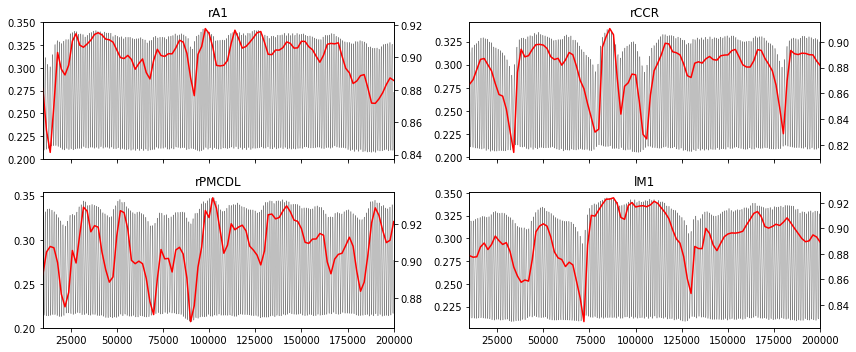

In [37]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(12,5))

a = ax[0][0]; a.set_title(df_tavg.columns[0])
df_tavg.loc[10000:].iloc[:,0].plot(legend=False,alpha=0.5,ax=a,linewidth=0.5,c='k')
df_bold.loc[10000:].iloc[:,0].plot(secondary_y=True,legend=False,ax=a,c='r')

a = ax[0][1]; a.set_title(df_tavg.columns[5])
df_tavg.loc[10000:].iloc[:,5].plot(legend=False,alpha=0.5,ax=a,linewidth=0.5,c='k')
df_bold.loc[10000:].iloc[:,5].plot(secondary_y=True,legend=False,ax=a,c='r')

a = ax[1][0]; a.set_title(df_tavg.columns[25])
df_tavg.loc[10000:].iloc[:,25].plot(legend=False,alpha=0.5,ax=a,linewidth=0.5,c='k')
df_bold.loc[10000:].iloc[:,25].plot(secondary_y=True,legend=False,ax=a,c='r')

a = ax[1][1]; a.set_title(df_tavg.columns[50])
df_tavg.loc[10000:].iloc[:,50].plot(legend=False,alpha=0.5,ax=a,linewidth=0.5,c='k')
df_bold.loc[10000:].iloc[:,50].plot(secondary_y=True,legend=False,ax=a,c='r')

plt.tight_layout()

This is even visible to some extend in the average over nodes:

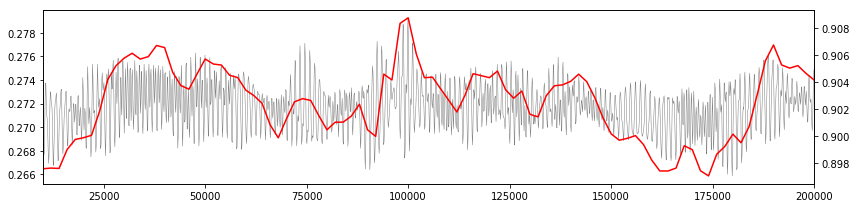

In [38]:
fig, ax = plt.subplots(figsize=(12,3))
df_tavg.loc[10000:].mean(axis=1).plot(ax=ax,alpha=0.5,linewidth=0.5,c='k')
df_bold.loc[10000:].mean(axis=1).plot(ax=ax,secondary_y=True,c='r')
plt.tight_layout()

The aim of the following is to reproduce the BOLD signal shown above, directly from the neural signal.

## Computing BOLD signal post-hoc 

First let's take a look at the BOLD monitor and its HRF functions.

The meat of the BOLD monitor is the `equations` object cfound in the `.hrf_kernel` attribute:

In [39]:
monitors.Bold()

Parameter,Value,Description
hrf_kernel,"FirstOrderVolterra(bound=False, value=None)",A tvb.datatypes.equation object which describe the haemodynamic response function used to compute the BOLD signal.
period,2000.0,"For the BOLD monitor, sampling period in milliseconds must be an integral multiple of 500. Typical measurment interval (repetition time TR) is between 1-3 s. If TR is 2s, then Bold period is 2000ms."
hrf_length,20000.0,Duration of the hrf kernel
variables_of_interest,[],"Indices of model's variables of interest (VOI) that this monitor should record. Note that the indices should start at zero, so that if a model offers VOIs V, W and V+W, and W is selected, and this monitor should record W, then the correct index is 0."


The default bold monitor equation is the following first order Volterra kernel:

In [40]:
monitors.Bold().hrf_kernel.equation

'1/3. * exp(-0.5*(var / tau_s)) * (sin(sqrt(1./tau_f - 1./(4.*tau_s**2)) * var)) / (sqrt(1./tau_f - 1./(4.*tau_s**2)))'

Borrowing from the TVB bold monitor demo, we can plot the shape of this function (and ther other available HRF kernels) as follows:

In [41]:
def tvb_bold_hrf(times=None,mon_params={},return_df=True):
    
    """
    times   = array of time steps to evaluate respons (unit = ms)
    mon_params = bold monitor parameters dict
    """
    
    bold_mon = monitors.Bold(**mon_params)

    hrfkeqn = bold_mon.hrf_kernel
    label = hrfkeqn.__class__.__name__
    
    if times is None:
        times = np.linspace(0,bold_mon.hrf_length,100)/1000.
    
    hrfkeqn._set_pattern(times)
    
    res = hrfkeqn.pattern 
    # (note 'pattern' here is a decorator; i.e. this expression
    # is actually evaluating a function
    # (computing hrf equation for the specified times and parameters)
    
    if return_df:
        df = pd.DataFrame(res,index=times,columns=[label])
        return df
    else:
        return res

    # Alternative; gives slightly different result though (?)
    #  hrf_params = bold_mon.hrf_kernel.parameters
    #  eqn_str = bold_mon.hrf_kernel.equation
    #  hrf_params.update({'var': times})
    #  res = evaluate(eqn_str,local_dict=hrf_params)


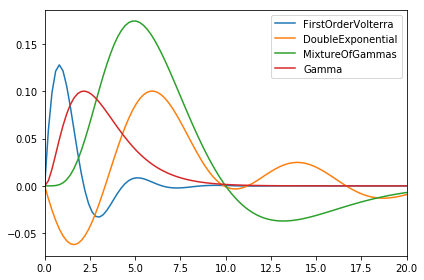

In [47]:
hrf_kernels = [equations.FirstOrderVolterra(),
               equations.DoubleExponential(),
               equations.MixtureOfGammas(),
               equations.Gamma()]
fig, ax = plt.subplots()
for k in hrf_kernels:
    tvb_bold_hrf(mon_params={'hrf_kernel': k}).plot(ax=ax)       
plt.tight_layout()

We'll now use the above function to construct our convolution function for computing bold from neural activity time series

In [44]:
def compute_bold_from_ts(data,times,hrf_len=500,scale_time=1E-3,n_subsamp=20,winlen=10):
    
    hrf_time = times[:hrf_len]*scale_time
    hrf_at_time = tvb_bold_hrf(times=hrf_time,return_df=False)

    data_conv = convolve(data,hrf_at_time)
    n_to_remove = len(hrf_at_time) - 1
    data_conv = data_conv[:-n_to_remove]
    
    idxs = np.arange(0,times.shape[0],n_subsamp)
    
    df_data_conv = pd.DataFrame(data_conv,index=times)
    
    df_data_conv_rwm = df_data_conv.rolling(window=winlen).mean()
    
    df_data_conv_rwm_ss = df_data_conv_rwm.iloc[idxs,:]
    
    return df_data_conv_rwm,df_data_conv_rwm_ss

Applying this to the simulated data:

In [45]:
times = df_tavg.index.values    # time stamps
stuff = {}
for c in range(df_tavg.columns.shape[0]):
    data = df_tavg.iloc[:,c].values
    stuff[c] = compute_bold_from_ts(data,times)
df_data_conv_rwm_all = pd.concat({k: v[0][0] for k,v in stuff.items()},axis=1)
df_data_conv_rwm_ss_all = pd.concat({k: v[1][0] for k,v in stuff.items()},axis=1)

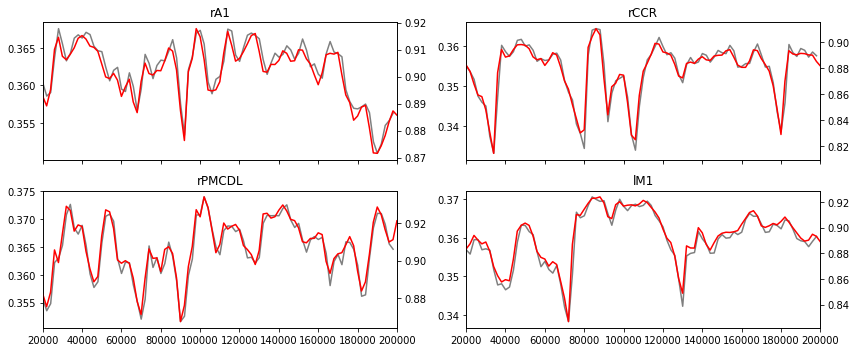

In [46]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(12,5))

a = ax[0][0]; a.set_title(df_tavg.columns[0])
df_data_conv_rwm_ss_all.loc[20000:].iloc[:,0].plot(legend=False,alpha=0.5,ax=a,c='k')
df_bold.loc[20000:].iloc[:,0].plot(secondary_y=True,legend=False,ax=a,c='r')

a = ax[0][1]; a.set_title(df_tavg.columns[5])
df_data_conv_rwm_ss_all.loc[20000:].iloc[:,5].plot(legend=False,alpha=0.5,ax=a,c='k')
df_bold.loc[20000:].iloc[:,5].plot(secondary_y=True,legend=False,ax=a,c='r')

a = ax[1][0]; a.set_title(df_tavg.columns[25])
df_data_conv_rwm_ss_all.loc[20000:].iloc[:,25].plot(legend=False,alpha=0.5,ax=a,c='k')
df_bold.loc[20000:].iloc[:,25].plot(secondary_y=True,legend=False,ax=a,c='r')

a = ax[1][1]; a.set_title(df_tavg.columns[50])
df_data_conv_rwm_ss_all.loc[20000:].iloc[:,50].plot(legend=False,alpha=0.5,ax=a,c='k')
df_bold.loc[20000:].iloc[:,50].plot(secondary_y=True,legend=False,ax=a,c='r')


plt.tight_layout()

Excellent. We can see that the new post-hoc computed BOLD activity, and the outputs of the TVB BOLD monitor match up very nicely. 

## Additional Notes


- Absolute value of the bold monitor output at the new function here arent currently matching. Hence use of `secondary_y` axis in above plots. Not quite sure why this is. 
- With this implementation, the post-hoc computed BOLD activity only starts to follow the BOLD monitor activity after the initial transient of a few seconds. This is probably due to either the moving average window length or the convolution window length; neither of which were tuned to any great deal in the above. 
- Effects of moving average window length and convolution window length should perhaps be investigated. 
